# **Project 2**, APS1070 Fall 2023
**Anomaly Detection Algorithm using Gaussian Mixture Model**

**Deadline: OCT 27, 11 PM**



##**Part 1: Getting started [1.5 Marks]**

We are going to work with a [credit card fraud detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) dataset, consisting of transactions made by credit cards in September 2013 by European cardholders. The dataset contains only numerical input variables (`V1`, `V2`, … `V28`) which are the principal components obtained with PCA transformation (PCA will the introduced later in this course), due to confidentiality issues. The only features which have not been transformed with PCA are `Time` (seconds elapsed between each transaction and the first transaction in the dataset) and `Amount` (transaction Amount).\
This dataset contains 30 key features, which are not
directly interpretable but contain meaningful information about the dataset.
Load the dataset in CSV file using Pandas. The dataset is called `creditcard.csv`. Print out the first few columns of the dataset.

* How many rows are there? 284807  **[0.1]**
* Which column contains the targets? The last column, Class **[0.1]**
* What is the meaning of target values? 0 means regular transactions and 1 means fraud **[0.2]**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv(filepath_or_buffer='/content/creditcard.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

It's important to know how many examples we have for each class when we work with a new dataset.

 What is the percentage of entries in the dataset for each class?
* Normal transactions: Roughly 99.83%
* Fraudulent transactions: Roughly 0.17%

Is this data considered balanced or unbalanced? Why is this the case?
* Unbalanced, vast amount of transactions are normal while only a tiny percentage of transactions are fraudulent.

Why is balance/imbalance important? How might this class ditribution affect a KNN classifier for example, which we explored in Project 1?
* When one class vastly outnumbers the other, the classifier may become biased towards predicting the majority class. In the context of KNN, it's much more likely to contain samples from the majority class. Thus, KNN could often classify a fraudulent instance as belonging to the normal instance.


What metrics should we use to evaluate a model in such cases
* Recall, as it minimizes FN by allowing more FP, which means we wanna catch as many fraudulent trasanctions as possible, even if is at the cost of having some false positives.


In [ ]:
normal = len(df[df['Class'] == 0]) / df.shape[0]
fraudulent = len(df[df['Class'] == 1]) / df.shape[0]
normal, fraudulent

(0.9982725143693799, 0.001727485630620034)

Next, split the dataset into a training (70%), validation (15%) and testing set (15%). Set the random state to 0. **[0.2]**

Make sure to separate out the column corresponding to the targets.

In [ ]:
### Split the data  ###
X = df.drop(['Class'],axis = 1)
y = df['Class']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=0)

Now, let's take a look at the difference in distribution for all variables between non-fraudulent and fraudulent credit card transactions:

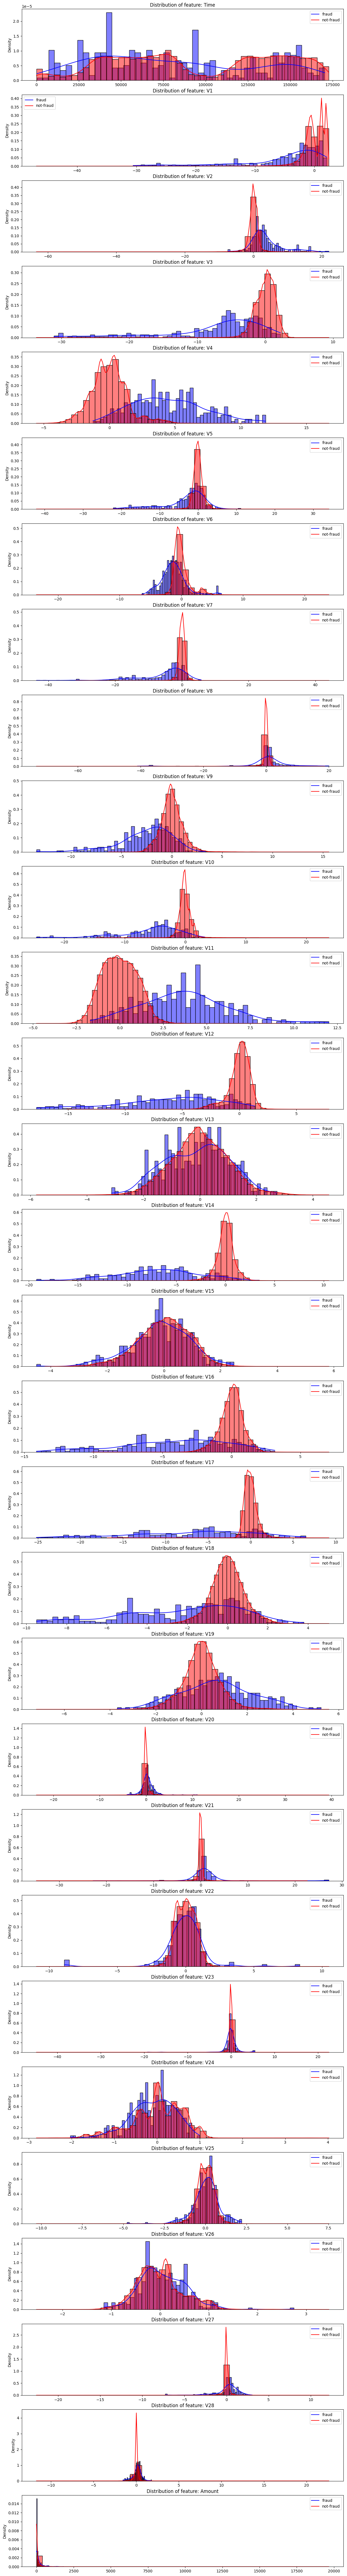

In [ ]:
import matplotlib.gridspec as gridspec

features=[f for f in df.columns if not 'Class' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.histplot(X_train[feat][y_train==1], stat="density", kde=True, color="blue", bins=50)
    sns.histplot(X_train[feat][y_train==0], stat="density", kde=True, color="red", bins=50)
    ax.legend(['fraud', 'not-fraud'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

Explain how these graphs could provide meaningful information about anomaly detection using a gaussian model. **[0.5]**

1. If the distributions of a feature for fraudulent and non-fraudulent transactions are clearly distinct, then that feature is highly discriminative.
2. The Gaussian distribution has a bell-shaped curve. If a feature's distribution closely resembles a Gaussian distribution for one or both classes, then it's particularly suitable for a Gaussian anomaly detection model.
3. If the distribution of a feature for fraudulent transactions lies in the tails of the distribution for non-fraudulent transactions, it indicates that extreme values of that feature are indicative of fraud.


## **Part 2: Single feature model with one Gaussian distribution: [2.5 Marks]**
We'll start by making a prediction using **a single feature of our dataset at a time**.

Please note that we **only use `V` features** in our model.

**a. Fitting regardless of class:**
  1. Fit a single Gaussian distribution on a single feature of **the full training dataset** (both classes) using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``.
  2. Compute AUC (Area under the ROC Curve) based on ``sklearn.mixture.GaussianMixture.score_samples`` on both the full training set and validation set (including both classes).  
  3. Repeat the above steps for each of the features and present your findings in a table.
  4. Find the best 3 features to distinguish fraud transactions from not-fraud transactions based on the AUC of the validation set. **[0.2]**
  5. Make a prediction based on a model's scores: If the `score_samples` is lower than a threshold, we consider that transaction as a fraud. Find an optimal threshold that maximizes the F1 Score of the validation set for each of those 3 features separately. (Do not check every possible value for threshold, come up with a faster way!) Compute F1 score using `sklearn.metrics.f1_score`. **[0.5]**
  6. Report the complexity of your method (Big O notation) for determining the optimal threshold.**[0.5]**

**b. Fitting based on class:**
 1. Pick 3 features that had the best AUC in Part 2a.
 2. Compute AUC and F1 score when you fit a Gaussian **only on not-fraud transactions** (instead of all the transactions).
 3. Compare your results from parts 2a and 2b (AUC and F1 score) in a table. **[0.8]**
 4. Are these results different or similar? Why?**[0.5]**





In [ ]:
# Fitting regardless of class
# Q1,2&3
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_auc_score

features = [col for col in X.columns if 'V' in col]

feature_list = []
train_aucs = []
val_aucs = []

for feature in features:
    gmm = GaussianMixture(n_components=1)
    gmm.fit(X_train[[feature]])

    train_scores = gmm.score_samples(X_train[[feature]])
    val_scores = gmm.score_samples(X_val[[feature]])

    train_auc = roc_auc_score(y_train, -train_scores)
    val_auc = roc_auc_score(y_val, -val_scores)

    feature_list.append(feature)
    train_aucs.append(train_auc)
    val_aucs.append(val_auc)

results_df = pd.DataFrame({
    'Feature': feature_list,
    'Train AUC': train_aucs,
    'Validation AUC': val_aucs
})

results_df
# Q4
top_3_features = results_df.sort_values(by="Validation AUC", ascending=False).head(3)
top_3_features = ['V14', 'V10', 'V4']


In [ ]:
# Fitting regardless of class
# Q5
from sklearn.metrics import f1_score

best_thresholds = {}

for feature in top_3_features:
    gmm.fit(X_train[[feature]])
    val_scores = gmm.score_samples(X_val[[feature]])

    sorted_scores = np.sort(val_scores)

    percentiles = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]
    thresholds = np.percentile(sorted_scores, percentiles)

    best_f1 = 0
    best_thresh = None

    for thresh in thresholds:
        predictions = (val_scores < thresh).astype(int)
        f1 = f1_score(y_val, predictions)

        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh

    best_thresholds[feature] = best_thresh
best_thresholds


{'V14': -5.902131100660686,
 'V10': -6.579030253821418,
 'V4': -5.788283899132653}

a - Q6

The complexity of finding the optimal threshold for each feature is O(N log N) for sorting the scores, where N is the number of observations in the validation set. Since we are considering a fixed number of percentiles, the overall complexity for each feature remains O(N log N).

In [ ]:
# Fitting based on class
auc_scores_2b = {}
f1_scores_2b = {}

X_train_not_fraud = X_train[y_train == 0]

for feature in top_3_features:

    gmm.fit(X_train_not_fraud[[feature]])
    val_scores = gmm.score_samples(X_val[[feature]])

    val_auc = roc_auc_score(y_val, val_scores)
    auc_scores_2b[feature] = val_auc

    sorted_scores = np.sort(val_scores)
    thresholds = np.percentile(sorted_scores, percentiles)
    best_f1 = 0
    best_thresh = None

    for thresh in thresholds:
        predictions = (val_scores < thresh).astype(int)
        f1 = f1_score(y_val, predictions)

        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh

    f1_scores_2b[feature] = best_f1

train_auc_dict = {}
val_auc_dict = {}

for feature in features:

    gmm = GaussianMixture(n_components=1)
    gmm.fit(X_train[[feature]])

    train_scores = gmm.score_samples(X_train[[feature]])
    val_scores = gmm.score_samples(X_val[[feature]])

    train_auc = roc_auc_score(y_train, -train_scores)
    val_auc = roc_auc_score(y_val, -val_scores)

    train_auc_dict[feature] = train_auc
    val_auc_dict[feature] = val_auc

comparison_df = pd.DataFrame({
    'Feature': top_3_features,
    'AUC_2a': [train_auc_dict[feat] for feat in top_3_features],
    'AUC_2b': [val_auc_dict[feat] for feat in top_3_features],
    'F1_Score_2a': [best_thresholds[feat] for feat in top_3_features],
    'F1_Score_2b': [f1_scores_2b[feat] for feat in top_3_features]
})

print(comparison_df)

  Feature    AUC_2a    AUC_2b  F1_Score_2a  F1_Score_2b
0     V14  0.952459  0.938073    -5.902131     0.210101
1     V10  0.913600  0.905959    -6.579030     0.141414
2      V4  0.892103  0.888283    -5.788284     0.113131


b - Q4

the AUCs being similar suggests that the fraudulent transactions are not dramatically altering the feature distributions. The differences in F1 scores could be related to how sensitive the model is to detecting fraud when trained only on non-fraudulent transactions.

## **Part 3: Multiple feature model with one Gaussian distribution: [1 Marks]**
This part is similar to Part 2, but we will pick multiple features and **visually** set the number of components.

  a. 2D plot:
 1. Pick two features (say, f1 and f2).
 2. Scatter plot (plt.scatter) those features on a figure (f1 on the x-axis and f2 on the y-axis).
 3. Color the data points based on their class (not-fraud blue and fraud red).
 4. Based on your plots, decide how many Gaussian components (``n_components``) you need to fit the data (focus on valid transactions). Explain.  **[0.25]**
 5. Fit your Gaussian model on all the data points.
 6. Compute AUC on both training and validation sets
 7. Pick 3 new pairs of features and repeat steps 2 to 6. **[0.25]**
 8. For each pair, find a threshold to maximize your validation set F1 Score.**[0.25]**
 9. For each pair, plot a figure similar to step 3 and put a circle around outliers based on your threshold (use the code of the similar figure in the tutorial) **[0.25]**





Best F1 Score for V4 and V14: 0.21414141414141413
Best Threshold for V4 and V14: -8.824835875092333


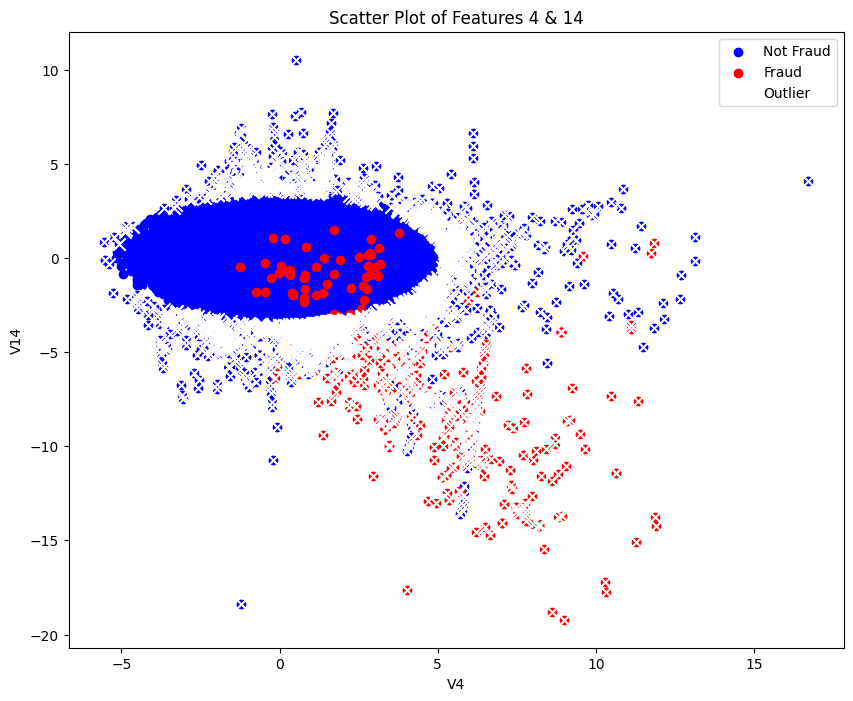

In [ ]:
f11, f21 = 'V4', 'V14'

gmm = GaussianMixture(n_components=1, random_state=0)
gmm.fit(X_train[[f11, f21]])

train_scores = gmm.score_samples(X_train[[f11, f21]])
val_scores = gmm.score_samples(X_val[[f11, f21]])

train_auc = roc_auc_score(y_train, -train_scores)
val_auc = roc_auc_score(y_val, -val_scores)

best_f1 = 0
best_thresh = None

sorted_scores = np.sort(val_scores)

thresholds = np.percentile(sorted_scores, percentiles)

for thresh in thresholds:
    predictions = (val_scores < thresh).astype(int)
    f1 = f1_score(y_val, predictions)

    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"Best F1 Score for V4 and V14: {best_f1}")
print(f"Best Threshold for V4 and V14: {best_thresh}")

plt.figure(figsize=(10, 8))
plt.scatter(X_train[y_train == 0][f11], X_train[y_train == 0][f21], c='blue', label='Not Fraud')
plt.scatter(X_train[y_train == 1][f11], X_train[y_train == 1][f21], c='red', label='Fraud')
outliers = (train_scores < best_thresh)
plt.scatter(X_train[outliers][f11], X_train[outliers][f21], s=80, color='white', marker = 'x', label='Outlier')
plt.xlabel(f11)
plt.ylabel(f21)
plt.legend()
plt.title('Scatter Plot of Features 4 & 14')
plt.show()

Best F1 Score for V4 and V10: 0.15353535353535355
Best Threshold for V4 and V10: -10.344046115002147


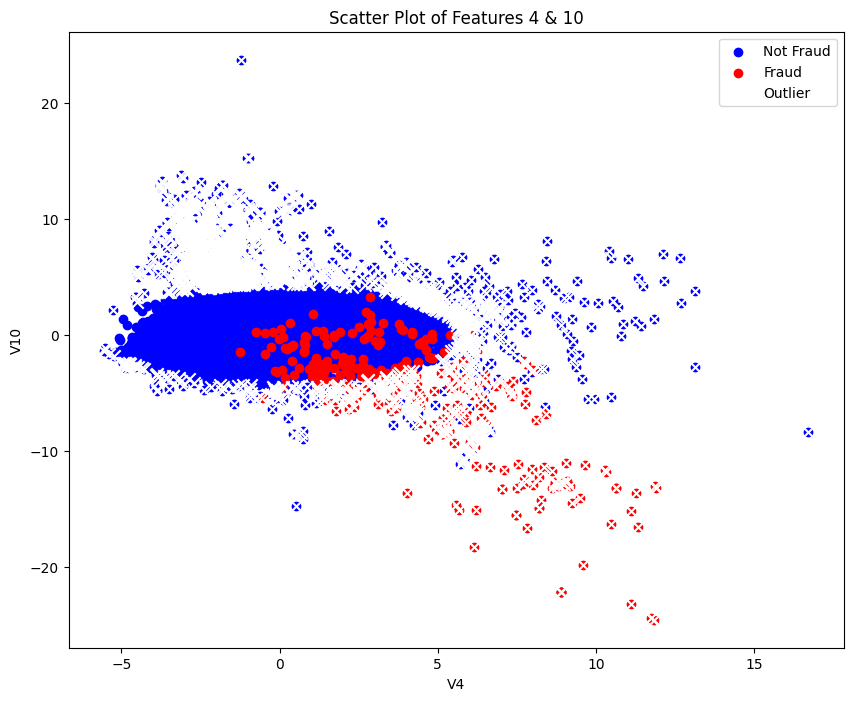

In [ ]:
f12, f22 = 'V4', 'V10'

gmm = GaussianMixture(n_components=1, random_state=0)
gmm.fit(X_train[[f12, f22]])

train_scores = gmm.score_samples(X_train[[f12, f22]])
val_scores = gmm.score_samples(X_val[[f12, f22]])

train_auc = roc_auc_score(y_train, -train_scores)
val_auc = roc_auc_score(y_val, -val_scores)

best_f1 = 0
best_thresh = None

sorted_scores = np.sort(val_scores)

thresholds = np.percentile(sorted_scores, percentiles)

for thresh in thresholds:
    predictions = (val_scores < thresh).astype(int)
    f1 = f1_score(y_val, predictions)

    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"Best F1 Score for V4 and V10: {best_f1}")
print(f"Best Threshold for V4 and V10: {best_thresh}")

plt.figure(figsize=(10, 8))
plt.scatter(X_train[y_train == 0][f12], X_train[y_train == 0][f22], c='blue', label='Not Fraud')
plt.scatter(X_train[y_train == 1][f12], X_train[y_train == 1][f22], c='red', label='Fraud')
outliers = (train_scores < best_thresh)
plt.scatter(X_train[outliers][f12], X_train[outliers][f22], s=80, color='white', marker = 'x', label='Outlier')
plt.xlabel(f12)
plt.ylabel(f22)
plt.legend()
plt.title('Scatter Plot of Features 4 & 10')
plt.show()


Best F1 Score for V10 and V14: 0.20606060606060606
Best Threshold for V10 and V14: -11.159125632794028


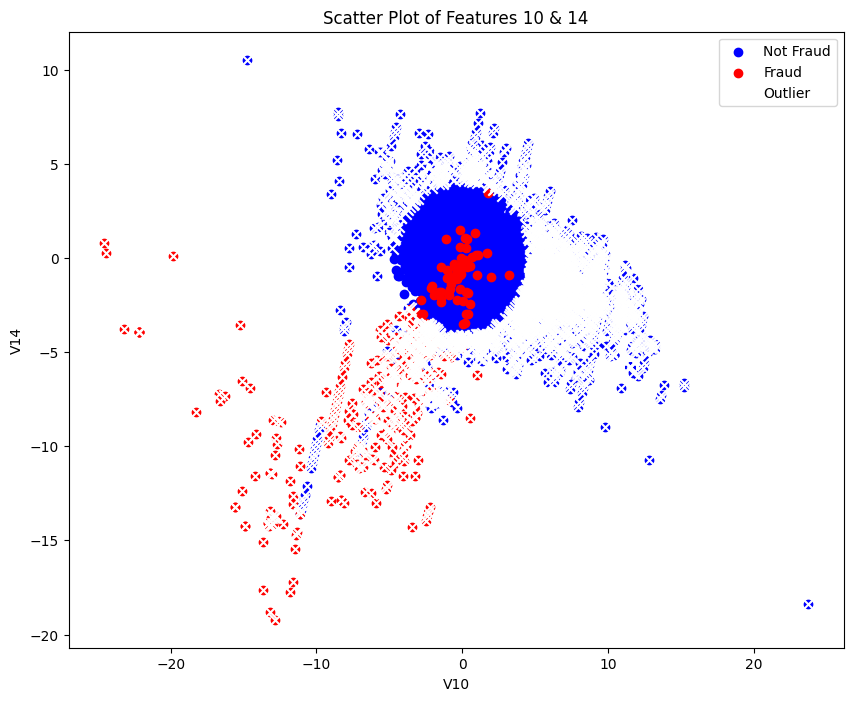

In [ ]:
f13, f23 = 'V10', 'V14'

gmm = GaussianMixture(n_components=1, random_state=0)
gmm.fit(X_train[[f13, f23]])

train_scores = gmm.score_samples(X_train[[f13, f23]])
val_scores = gmm.score_samples(X_val[[f13, f23]])

train_auc = roc_auc_score(y_train, -train_scores)
val_auc = roc_auc_score(y_val, -val_scores)

best_f1 = 0
best_thresh = None

sorted_scores = np.sort(val_scores)

thresholds = np.percentile(sorted_scores, percentiles)

for thresh in thresholds:
    predictions = (val_scores < thresh).astype(int)
    f1 = f1_score(y_val, predictions)

    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"Best F1 Score for V10 and V14: {best_f1}")
print(f"Best Threshold for V10 and V14: {best_thresh}")

plt.figure(figsize=(10, 8))
plt.scatter(X_train[y_train == 0][f13], X_train[y_train == 0][f23], c='blue', label='Not Fraud')
plt.scatter(X_train[y_train == 1][f13], X_train[y_train == 1][f23], c='red', label='Fraud')
outliers = (train_scores < best_thresh)
plt.scatter(X_train[outliers][f13], X_train[outliers][f23], s=80, color='white', marker = 'x', label='Outlier')
plt.xlabel(f13)
plt.ylabel(f23)
plt.legend()
plt.title('Scatter Plot of Features 10 & 14')
plt.show()

Q4

By examining the distribution of data points for both classes in the three plots, it is apparent that the non-fraudulent transactions predominantly form one Gaussian component. This component clusters in a dense region which extends predominantly along the horizontal axis. However, in the third plot, this distribution appears to undergo a rotation in addition to its horizontal stretching. As for the fraudulent transactions, their spread is more diffuse, making it challenging to pinpoint a specific pattern. However, they seem to generally adhere to one Gaussian distribution that exhibits shearing in various directions. Thus my choice of **n_components** is one across three models for each class.

## **Part 4: Single feature model with two Gaussian distributions. [2 Marks]**
Now we will use two different distributions for fraud and not-fraud transactions.
  1.  Fit a Gaussian distribution ($G_1$) on a feature of **not-fraud transactions** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. **[0.25]**
  2. Fit another Gaussian distribution ($G_2$) on the same feature but for **fraud transactions** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. **[0.25]**
  3. Compute the score samples ($S$) for both $G_1$ and $G_2$ on the **validation set** to get $S_1$ and $S_2$, respectively. **[0.25]**
  4. Find an optimal $c$ (a real number) that maximizes validation set F1 Score for a model such that if $S_1 < c \times S_2$, the transaction is classified as an anomaly. For example, if $c=1$ we could say that if $S_2$ is greater than $S_1$, ($S_1$<$S_2$) then the transaction is an anomaly (the transaction belongs to the $G_2$ distribution which represents fraud transactions). For start consider $c$ in $[0,10]$ with steps of 0.1, you can change this window in your experiments if needed. **[0.25]**
  5. Repeat the steps above for all the features. What is the best F1 Score that you get for training and validation? Which feature and what c? **[1]**

In [ ]:
best_f1_train = 0
best_f1_val = 0
best_c = None
best_feature = None

for feature in features:
    # Step 1: Fit Gaussian on not-fraud transactions
    gmm1 = GaussianMixture(n_components=1)
    gmm1.fit(X_train[y_train == 0][[feature]])

    # Step 2: Fit Gaussian on fraud transactions
    gmm2 = GaussianMixture(n_components=1)
    gmm2.fit(X_train[y_train == 1][[feature]])

    # Step 3: Compute the score samples for both Gaussians
    S1_train = gmm1.score_samples(X_train[[feature]])
    S2_train = gmm2.score_samples(X_train[[feature]])

    S1_val = gmm1.score_samples(X_val[[feature]])
    S2_val = gmm2.score_samples(X_val[[feature]])

    # Step 4&5: Find optimal c
    for c in np.arange(0, 10.1, 0.1):
        pred_train = (S1_train < c * S2_train).astype(int)
        pred_val = (S1_val < c * S2_val).astype(int)

        f1_train = f1_score(y_train, pred_train)
        f1_val = f1_score(y_val, pred_val)

        if f1_val > best_f1_val:
            best_f1_val = f1_val
            best_f1_train = f1_train
            best_c = c
            best_feature = feature

print("Best F1 Score on Training Set:", best_f1_train)
print("Best F1 Score on Validation Set:", best_f1_val)
print("Best c:", best_c)
print("Best Feature:", best_feature)


Best F1 Score on Training Set: 0.6421725239616614
Best F1 Score on Validation Set: 0.6545454545454547
Best c: 7.2
Best Feature: V17


## **Part 7: Is Gaussian the only useful distribution? [1 Mark]**

Search for other distributions that could be used to model the data. How popular are they? Is there a specific situation where a distribution works better? How can we find a suitable distribution to model our data? Do not forget to include your references.




Other distributions such as the Cauchy distribution, known for its heavy tails, is good for modeling extreme values or outliers. Multivariate Bernoulli or Dirichlet Compound Multinomial (DCM) distributions are alternatives for categorical data. The choice of distribution depends on the data nature and anomaly detection task specifics. Methods like Exploratory Data Analysis, goodness-of-fit tests, and model comparison can help in finding a suitable distribution.

1.https://www.ritchieng.com/machine-learning-anomaly-detection/​.

2.https://www.datatechnotes.com/2020/04/anomaly-detection-with-gaussian-mixture.html​.